# TensorFlow - Basic Overview of functionality
Here is a quick overview of the basic features of TensorFlow:
- A Tensor is like a representation of a multidimensional arrays but specifically optimised for Neural Networks. It's like a numpy array.
- Tensor are immutable, to store mutable value (model weights or other mutable state) we can use tf.Variable.
- Automatic differentation is implemented by TensorFlow and this allows it to perform gradient descent (=taking repeated steps in the opposite direction of the gradient (derivative)
- TensorFlow provides performance optimisation tool to speed up training and inferance
  - To separate pure python code with TensorFlow code, we need to use the @tf.function decorator on top of function declaration
    ```python
    @tf.function
    def my_func(x):
        print('Tracing.\n')
        return tf.reduce_sum(x)
    ```
  - The first time a tf.function is run, it executes in Python and capture a complete optimized graph representing the TensorFlow computations done withing the function
  - On subsequent calls, TensorFlow only executes the optimised graph, skipping any non-TensorFlow steps.
  - A graph may not be reusable for inputs with a difference signature (different shape or dtype)

## Let's see below an example of a training loop using all the concept explained above

In [2]:
import tensorflow as tf

import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

2023-02-05 00:34:18.044498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 00:34:31.610548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-05 00:34:31.610627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-05 00:34:31.610633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

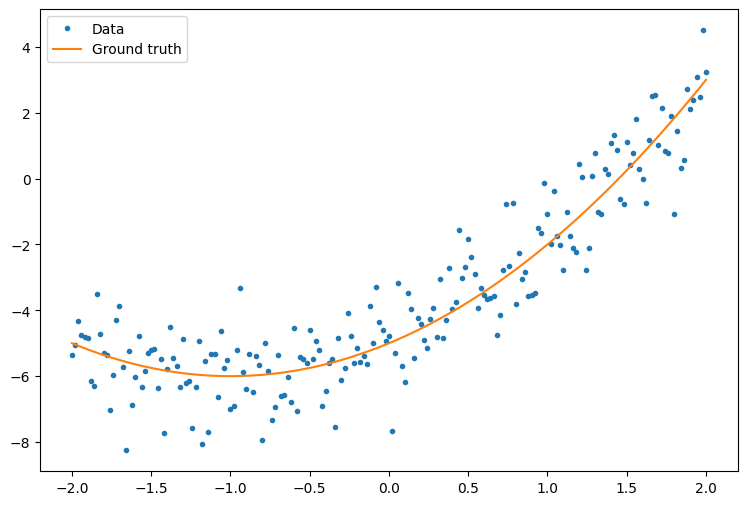

In [12]:
# Generates a cloud of points that loosely follows a quadratic curve:

x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
    y = x**2 + 2*x - 5
    return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x, y, '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend()

In [40]:
# Create a quadratic model with randomly initialized weights and a bias.

class Model(tf.Module):
    def __init__(self):
        #super(Model).__init__()
        # Randomly generate weight and bias terms
        rand_init = tf.random.uniform(shape=[3], minval=0.0, maxval=5.0, seed=22)

        # Initialise model parameters
        self.w_q = tf.Variable(rand_init[0])
        self.w_l = tf.Variable(rand_init[1])
        self.b = tf.Variable(rand_init[2])

    @tf.function
    def __call__(self, x):
        # Quadratic Model : quadratic_weight * x² + linear_weight * x + bias
        # A Quadratic is just a function that when placed on a graph draw a hyperbola
        return self.w_q * (x**2) + self.w_l * x + self.b

In [41]:
quad_model = Model()

In [42]:
# Observe model performance before training
def plot_preds(x, y, f, model, title):
    plt.figure()
    plt.plot(x, y, '.', label='Data')
    plt.plot(x, f(x), label='Ground truth')
    plt.plot(x, model(x), label='Predictions')
    plt.title(title)
    plt.legend()

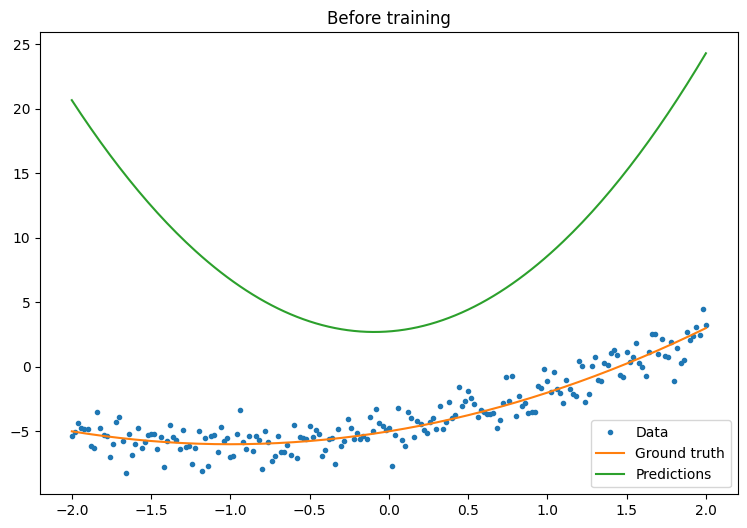

In [43]:
plot_preds(x, y, f, quad_model, 'Before training')

### Let's now define a loss for the model
The model is intended to predict continuous value so the Mean Squared Error (MSE) is a good choice for the loss function
![MSE](https://i.imgur.com/S5nvh2e.png)

In [44]:
def mse_loss(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

Write a basic training loop. The loop will make use of the MSE loss function and its gradients with respect to the input in order to iteratively update the model's parameters. The use of mini-batches for training provides memory efficienciy and faster convergence. The tf.data.Dataset API has useful functions for batching and shuffling.

In [45]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 68.960
Mean squared error for step 10: 4.212
Mean squared error for step 20: 2.101
Mean squared error for step 30: 1.374
Mean squared error for step 40: 1.131
Mean squared error for step 50: 1.042
Mean squared error for step 60: 1.010
Mean squared error for step 70: 0.999
Mean squared error for step 80: 0.996
Mean squared error for step 90: 0.995




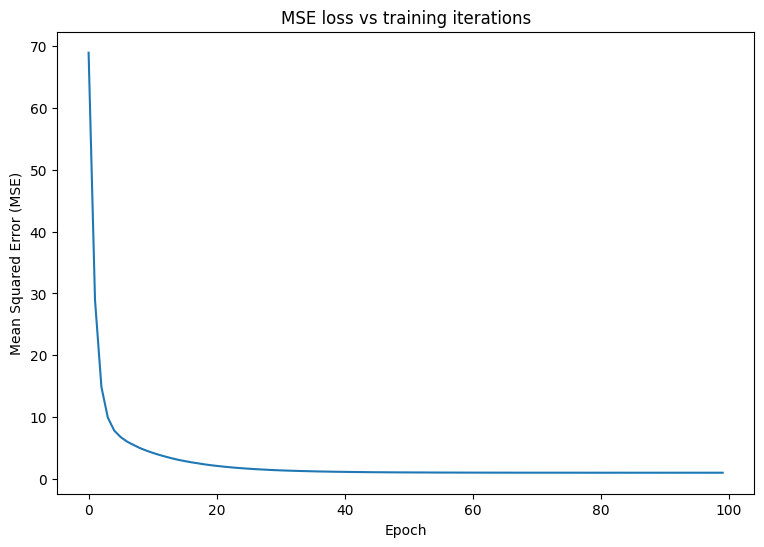

In [46]:
# Set hyperparameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
    for x_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            batch_loss = mse_loss(quad_model(x_batch), y_batch)

        # Update parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, quad_model.variables)
        for grad, variable in zip(grads, quad_model.variables):
            variable.assign_sub(learning_rate * grad)

    # Keep track of model loss per epoch
    loss = mse_loss(quad_model(x), y)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot result
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE loss vs training iterations");

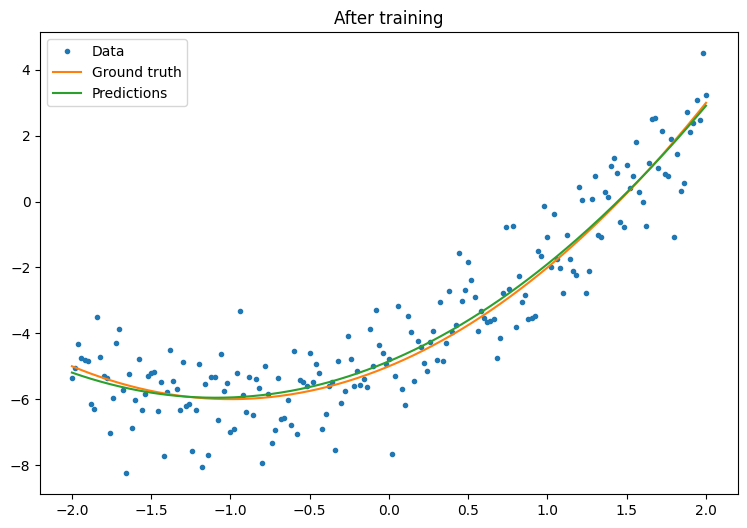

In [47]:
# Now, observes model's performance after trianing:
plot_preds(x, y, f, quad_model, 'After training')

### The above code is working, but all of this can be done in a simpler way using the keras module

Let's begin by creating a Sequential Model in Keras. We will use the simplest Keras layers, a dense layer. The dense layer is able to learn multidimensional linear relationships of the form $Y = WX + \overrightarrow{b}$.
In order to learn a nonlinear equation of the form, $w_1x²+w_2x+b$, the dense layer's input should be a data matrix with $x²$ and $x$ as features. The **lambda** layer can be used to perform this stacking transformation.

In [49]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)
])

In [50]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
)

history = new_model.fit(x, y, epochs=100, batch_size=32, verbose=0)

new_model.save('./my_new_model')

2023-02-05 01:18:21.858376: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e055ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-05 01:18:21.858445: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-02-05 01:18:25.010262: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-05 01:18:25.512043: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1b9a997df0>, 139756540200240), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1b9aaa6a90>, 139757934473504), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1b9a997df0>, 139756540200240), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1b9aaa6a90>, 139757934473504), {}).


INFO:tensorflow:Assets written to: ./my_new_model/assets


INFO:tensorflow:Assets written to: ./my_new_model/assets


Text(0.5, 1.0, 'Keras training progress')

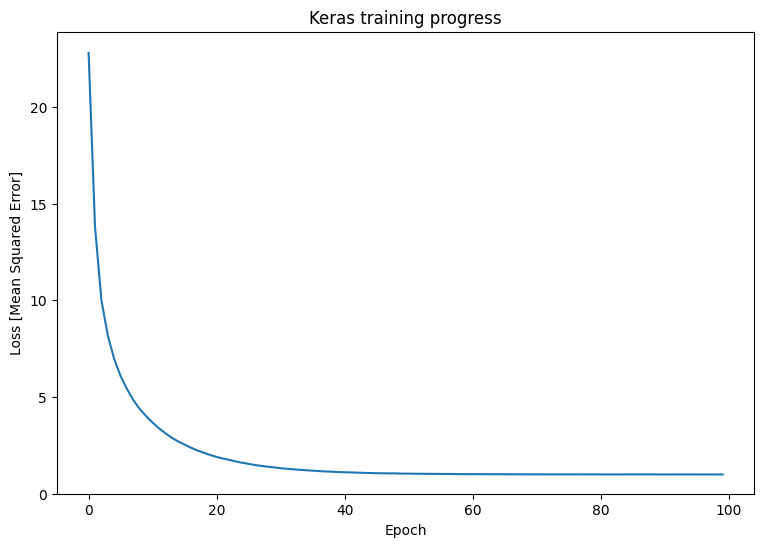

In [51]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress')

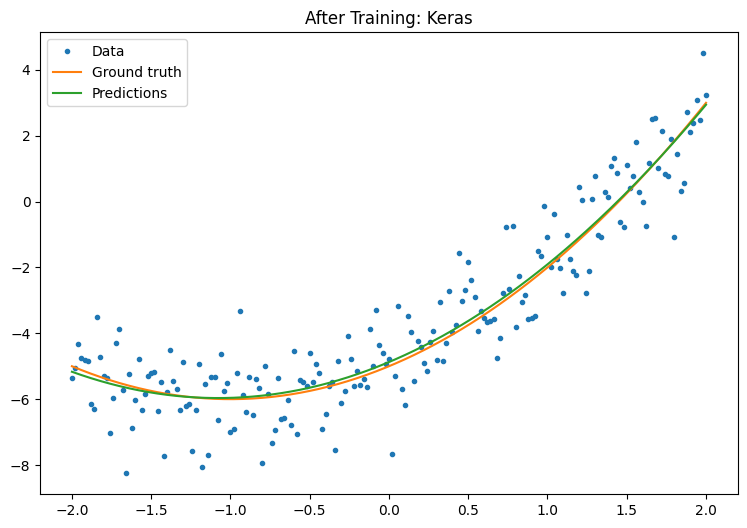

In [52]:
plot_preds(x, y, f, new_model, 'After Training: Keras')